In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pandas as pd
from datetime import datetime
import time

# # Assuming evaluate is defined elsewhere
# # from your_module import evaluate
import torch.optim as optim

from tqdm.auto import tqdm
from collections.abc import Iterable
import perceval as pcvl
from boson_sampler import BosonSampler
import numpy as np
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from utils import MNIST_partial, accuracy, plot_training_metrics

# from model import MnistModel, evaluate
import torch.nn as nn
import torch.nn.functional as F
# simulator = pcvl.Simulator(pcvl.NaiveBackend())

import warnings

warnings.filterwarnings("ignore")

In [2]:
# device = torch.device("cpu")
device = torch.device("cuda:0")

Boson sampler defined with number of parameters = 84, and embedding size = 70


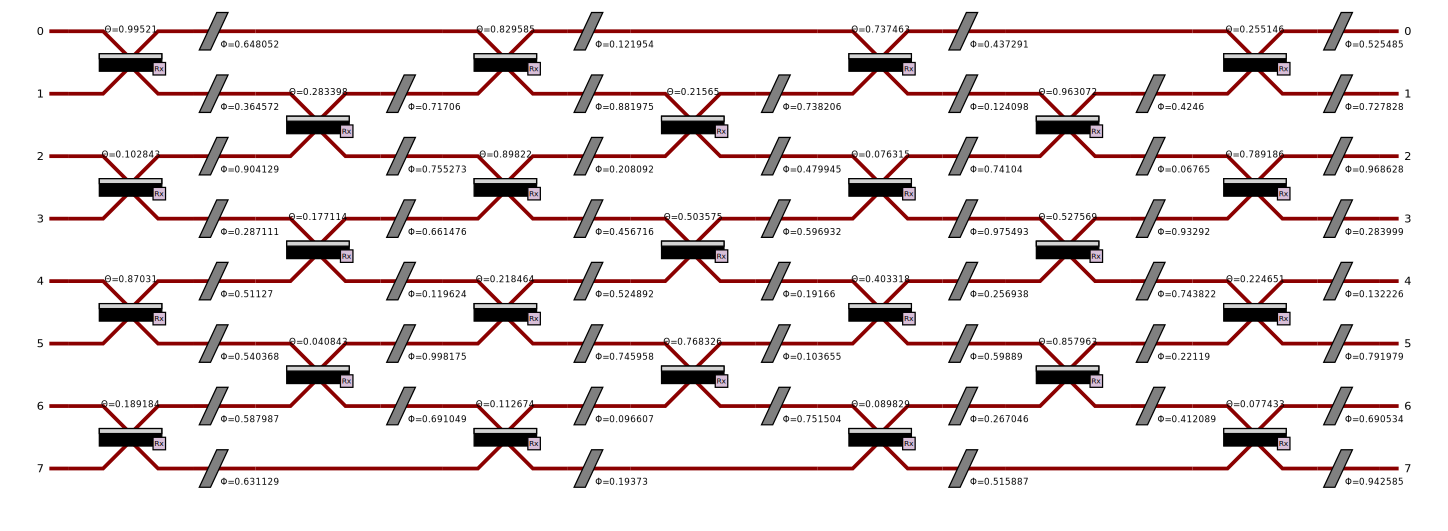

In [3]:
#### START SCALEWAY SESSION ####
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

#### BOSON SAMPLER DEFINITION ####

bs = BosonSampler(m=8, n=4, session=session)
print(
    f"Boson sampler defined with number of parameters = {bs.nb_parameters}, and embedding size = {bs.embedding_size}"
)
# to display it
pcvl.pdisplay(bs.create_circuit())

Boson sampler defined with number of parameters = 45, and embedding size = 20


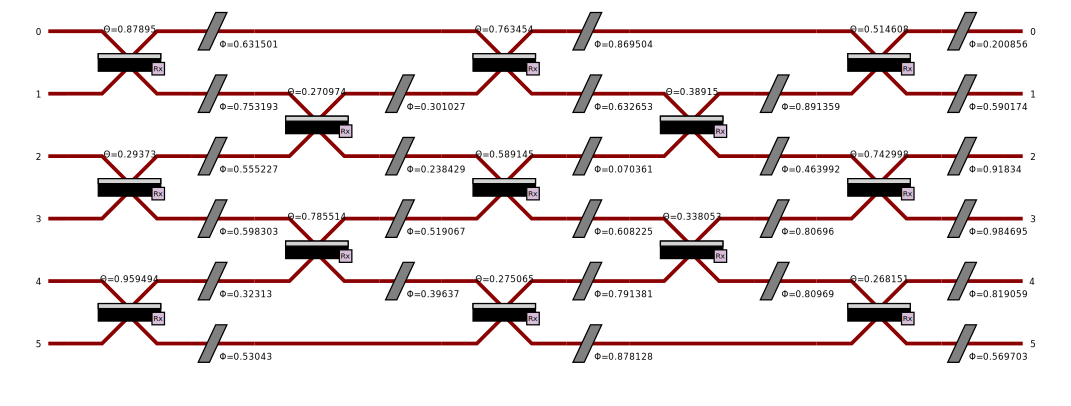

In [4]:
bs_2 = BosonSampler(m=6, n=3, session=session)
print(
    f"Boson sampler defined with number of parameters = {bs_2.nb_parameters}, and embedding size = {bs_2.embedding_size}"
)
pcvl.pdisplay(bs_2.create_circuit())

In [5]:
# random_para_tensor = torch.randn(30)
# res = bs.run(
#     parameters=random_para_tensor,
#     samples=100000
# )

# trans_res = bs.translate_results(res = res)
# print(trans_res)
# print(len(trans_res))
# count= 0
# for i in trans_res:
#     if i != 0:
#         count += 1
# print(count)

In [6]:
# random_para_tensor = torch.randn(30) - 0.5
# res = bs_2.run(
#     parameters=random_para_tensor,
#     samples=100000
# )

# trans_res = bs_2.translate_results(res = res)
# print(trans_res)

In [7]:
70 * 20

1400

In [8]:
31 * 31

961

In [9]:
# print(len(trans_res))

In [10]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=4)
        self.fc1 = nn.Linear(4 * 4 * 4, 10)
        # self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)  # [N, 32 * 8 * 8]
        x = self.fc1(x)
        # x = self.fc2(x)
        #     super(CNNModel, self).__init__()
        #     self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        #     self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #     self.conv2 = nn.Conv2d(8, 12, kernel_size=5)
        #     self.fc1 = nn.Linear(12*4*4, 20)
        #     self.fc2 = nn.Linear(20, 10)

        # def forward(self, x):
        #     x = self.pool(self.conv1(x))
        #     x = self.pool(self.conv2(x))
        #     x = x.view(x.size(0), -1) # [N, 32 * 8 * 8]
        #     x = self.fc1(x)
        #     x = self.fc2(x)
        return x


# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split="train")
val_dataset = MNIST_partial(split="val")

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [11]:
learning_rate = 1e-3
num_epochs = 1


# Instantiate the model and loss function
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_classical_parameter = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("# of parameters in classical CNN model: ", num_classical_parameter)

# of parameters in classical CNN model:  978


In [12]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}"
            )

Epoch [1/1], Step [100/375], Loss: 1.6709
Epoch [1/1], Step [200/375], Loss: 0.4705
Epoch [1/1], Step [300/375], Loss: 0.3280


In [13]:
# Testing loop
model.eval()
correct = 0
total = 0
loss_test_list = []
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

Accuracy on the test set: 85.00%


In [14]:
### required qubits estimation ##############
# NN weights

numpy_weights = {}
nw_list = []
nw_list_normal = []
for name, param in model.state_dict().items():
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

n_qubit = n_qubits

#############################################

# of NN parameters:  978
Required qubit number:  10


In [ ]:
### Some tool function definition ###########
def probs_to_weights(probs_):
    new_state_dict = {}
    data_iterator = probs_.view(-1)

    for name, param in CNNModel().state_dict().items():
        shape = param.shape
        num_elements = param.numel()
        chunk = data_iterator[:num_elements].reshape(shape)
        new_state_dict[name] = chunk
        data_iterator = data_iterator[num_elements:]

    return new_state_dict


def generate_qubit_states_torch(n_qubit):
    # Create a tensor of shape (2**n_qubit, n_qubit) with all possible combinations of 0 and 1
    all_states = torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])
    return all_states


#############################################

### Main Learning-wise Hybridization model ##


class PhotonicQuantumTrain(nn.Module):
    class MappingModel(nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size):
            super().__init__()
            # Initialize layers: an input layer, multiple hidden layers, and an output layer
            self.input_layer = nn.Linear(input_size, hidden_sizes[0])
            self.hidden_layers = nn.ModuleList(
                [
                    nn.Linear(hidden_sizes[i], hidden_sizes[i + 1])
                    for i in range(len(hidden_sizes) - 1)
                ]
            )
            self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        def forward(self, X):
            # Ensure the input tensor is the same type as the weights
            X = X.type_as(self.input_layer.weight)

            # Input layer with ReLU activation
            X = self.input_layer(X)

            # Hidden layers with ReLU activation
            for hidden in self.hidden_layers:
                X = hidden(X)

            # Output layer with linear activation
            output = self.output_layer(X)
            # output = F.tanh(output)  # It's often better to use ReLU or similar; tanh is used here as it was in the original model.
            return output

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
        super().__init__()
        self.MappingNetwork = self.MappingModel(n_qubit + 1, [20, 4], 1).to(device)
        # self.MappingNetwork = self.ConvMappingModel()
        # self.QuantumNN = nn.parameter(135)
        # self.bs = BosonSampler(m = 5, n = 5, session = session)
        # self.bs_2 = BosonSampler(m = 6, n = 6, session = session)

        self.q_params_1 = nn.Parameter(
            q_delta * torch.randn(84), requires_grad=True
        ).to(device)
        self.q_params_2 = nn.Parameter(
            q_delta * torch.randn(45), requires_grad=True
        ).to(device)
        # self.q_params_1.requires_grad = True
        # self.q_params_2.requires_grad = True
        # self.QLayer(q_depth).to(device)   #arch={"n_blocks": q_depth})

    def forward(self, x):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        device = x.device
        res_1 = bs.run(parameters=self.q_params_1, samples=100000)
        res_2 = bs_2.run(parameters=self.q_params_2, samples=100000)
        # print(res_1)
        # print(self.q_params_1)

        trans_res_1 = bs.translate_results(res=res_1)
        trans_res_2 = bs_2.translate_results(res=res_2)

        probs_1 = trans_res_1.to(device)
        probs_2 = trans_res_2.to(device)
        probs_1 = probs_1 / torch.sum(probs_1)
        probs_2 = probs_2 / torch.sum(probs_2)
        # print(probs_1)
        probs_ = torch.ger(probs_1, probs_2).flatten().reshape(70 * 20, 1)
        # probs_ = probs_
        # print(probs_)
        # probs_ = trans_res.to(device)

        # print(qt_model.MappingNetwork.input_layer.weight)
        probs_ = probs_[: len(nw_list_normal)]
        probs_ = probs_.reshape(len(nw_list_normal), 1)

        # Generate qubit states using PyTorch
        qubit_states_torch = generate_qubit_states_torch(n_qubit)[: len(nw_list_normal)]
        qubit_states_torch = qubit_states_torch.to(device)

        # Combine qubit states with probability values using PyTorch
        combined_data_torch = torch.cat((qubit_states_torch, probs_), dim=1)
        combined_data_torch = combined_data_torch.reshape(
            len(nw_list_normal), 1, n_qubit + 1
        )

        print(combined_data_torch)

        prob_val_post_processed = self.MappingNetwork(combined_data_torch)
        prob_val_post_processed = (
            prob_val_post_processed - prob_val_post_processed.mean()
        )

        state_dict = probs_to_weights(prob_val_post_processed)

        ########

        dtype = torch.float32  # Ensure all tensors are of this type

        # Convolution layer 1 parameters
        conv1_weight = state_dict["conv1.weight"].to(device).type(dtype)
        conv1_bias = state_dict["conv1.bias"].to(device).type(dtype)

        # Convolution layer 2 parameters
        conv2_weight = state_dict["conv2.weight"].to(device).type(dtype)
        conv2_bias = state_dict["conv2.bias"].to(device).type(dtype)

        # Fully connected layer 1 parameters
        fc1_weight = state_dict["fc1.weight"].to(device).type(dtype)
        fc1_bias = state_dict["fc1.bias"].to(device).type(dtype)

        # # Fully connected layer 2 parameters
        # fc2_weight = state_dict['fc2.weight'].to(device).type(dtype)
        # fc2_bias = state_dict['fc2.bias'].to(device).type(dtype)

        # Convolution 1
        x = F.conv2d(x, conv1_weight, conv1_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Convolution 2
        x = F.conv2d(x, conv2_weight, conv2_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected 1
        x = F.linear(x, fc1_weight, fc1_bias)

        # # Fully connected 2
        # x = F.linear(x, fc2_weight, fc2_bias)

        return x

In [94]:
### Training setting ########################

step = 1e-3  # Learning rate
batch_size = 16  # Number of samples for each training step
num_epochs = 50  # Number of training epochs
gamma_lr_scheduler = 0.1  # Learning rate reduction applied every 10 epochs.
q_delta = 0.1  # Initial spread of random quantum weights

# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Instantiate the model, move it to GPU, and set up loss function and optimizer
qt_model = PhotonicQuantumTrain().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(qt_model.parameters(), lr=step, weight_decay=1e-5, eps=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=5, verbose=True, factor=0.5
)  # 'min' because we're minimizing loss

num_trainable_params_MM = sum(
    p.numel()
    for p in PhotonicQuantumTrain.MappingModel(n_qubit + 1, [20, 4], 1).parameters()
    if p.requires_grad
)
# num_trainable_params_MM = sum(p.numel() for p in LewHybridNN.ConvMappingModel().parameters() if p.requires_grad)
num_trainable_params = sum(p.numel() for p in qt_model.parameters() if p.requires_grad)
print("# of trainable parameter in Mapping model: ", num_trainable_params_MM)
print(
    "# of trainable parameter in QNN model: ", bs_2.nb_parameters + bs.nb_parameters
)  # num_trainable_params - num_trainable_params_MM)
print("# of trainable parameter in full model: ", num_trainable_params)

# of trainable parameter in Mapping model:  329
# of trainable parameter in QNN model:  129
# of trainable parameter in full model:  329


In [95]:
#############################################
### Training loop ###########################

### (Optional) Start from pretrained model ##
# model = torch.load('result_FF_mm_b1000_40_200_40/tq_mm_acc_70_bsf')
# model.eval()  # Set the model to evaluation mode
#############################################

loss_list = []
acc_list = []
acc_best = 0
for epoch in range(num_epochs):
    qt_model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        correct = 0
        total = 0
        since_batch = time.time()

        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        # Forward pass
        outputs = qt_model(images)
        # print("output: ", outputs)
        labels_one_hot = F.one_hot(labels, num_classes=10).float()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Compute loss
        loss = criterion(outputs, labels_one_hot)
        # log_loss = torch.log(loss + 1e-6)

        loss_list.append(loss.cpu().detach().numpy())
        acc = 100 * correct / total
        acc_list.append(acc)
        train_loss += loss.cpu().detach().numpy()

        # np.array(loss_list).dump("L1/3/loss_list.dat")
        # np.array(acc_list).dump("L1/3/acc_list.dat")
        if acc > acc_best:
            # torch.save(model, 'L1/3/tq_mm_acc_'+str(int(acc))+'_bsf')
            acc_best = acc
        # Backward pass and optimization
        loss.backward()

        optimizer.step()
        # if (i+1) % 100 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}, accuracy:  {(acc):.2f}%"
        )

    train_loss /= len(train_loader)
    scheduler.step(train_loss)

#############################################

tensor([[[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00,  0.0000e+00]],

        [[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           1.0000e+00,  0.0000e+00]],

        [[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ...,  1.0000e+00,
          -1.0000e+00,  0.0000e+00]],

        ...,

        [[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  3.0444e-19]],

        [[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00,  2.1048e-20]],

        [[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ..., -1.0000e+00,
           1.0000e+00,  2.2649e-18]]], device='cuda:0')
Epoch [1/50], Step [1/375], Loss: 7.6505, batch time: 0.06, accuracy:  12.50%
tensor([[[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00,  0.0000e+00]],

        [[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           1.0000e+00,  0.0000e+00]],

        [[-1.0000e+00, -1.0000e+00,

KeyboardInterrupt: 

In [ ]:
for i in qt_model.parameters():
    print(i)

Parameter containing:
tensor([[ 0.0241,  0.2026,  0.1867,  0.1458,  0.2601, -0.1486,  0.0425,  0.1181,
         -0.2389,  0.2386,  0.2251],
        [ 0.1597,  0.2441,  0.0299, -0.0728, -0.2284, -0.2515,  0.1126, -0.2901,
          0.0855,  0.1745,  0.1132],
        [-0.1092, -0.2277,  0.2089, -0.1126, -0.2466, -0.0873,  0.2476,  0.0167,
          0.1272,  0.1015,  0.2873],
        [-0.1362, -0.1853,  0.0654, -0.3035,  0.0620, -0.0062,  0.0556, -0.1066,
          0.0671,  0.1994,  0.1813],
        [-0.2679, -0.1789,  0.2531, -0.0043, -0.0662, -0.2623, -0.2449, -0.1190,
         -0.0138, -0.0557, -0.2284],
        [-0.2759, -0.1921, -0.1381, -0.1433,  0.2618, -0.1099, -0.0166,  0.3033,
          0.0427, -0.1400,  0.0758],
        [ 0.2732,  0.1239, -0.2820, -0.2337,  0.1728, -0.2424,  0.2831,  0.0009,
         -0.0699, -0.2018,  0.2843],
        [-0.0338, -0.1307,  0.1282, -0.1623, -0.2150, -0.2458, -0.0247,  0.1823,
          0.0943,  0.0743, -0.0311],
        [ 0.2339,  0.1088, -0.2212

In [72]:
qt_model.q_params_1

tensor([ 0.0249, -0.0945,  0.0761, -0.0474, -0.0887,  0.1252,  0.0363, -0.1661,
        -0.1196, -0.0509, -0.0906, -0.1711,  0.0277,  0.0633, -0.1188, -0.0657,
         0.0305,  0.1731,  0.0381, -0.2204,  0.0260, -0.0703, -0.0477,  0.0256,
         0.0790,  0.1165, -0.0314,  0.0028, -0.2299, -0.0897,  0.0231, -0.1837,
        -0.0661,  0.0320,  0.0172,  0.1764,  0.0235,  0.0386,  0.0054,  0.0720,
         0.1034, -0.0103, -0.2568,  0.1611,  0.0179, -0.0888,  0.0916, -0.0566,
         0.0914, -0.0450,  0.1158,  0.1153, -0.0737, -0.3087,  0.0016,  0.1763,
        -0.0893,  0.0867,  0.0912, -0.0055,  0.0750,  0.0093, -0.0011,  0.0294,
         0.0242, -0.0047,  0.1169,  0.1743, -0.0955, -0.0456,  0.1874, -0.1788,
         0.0715, -0.0257,  0.0461,  0.2015,  0.1692, -0.0195,  0.0848,  0.0720,
        -0.0562, -0.0469, -0.0474, -0.0211], device='cuda:0',
       grad_fn=<ToCopyBackward0>)

In [73]:
qt_model.q_params_2

tensor([-0.0547,  0.0656,  0.2124,  0.0601,  0.0404, -0.0133,  0.0322,  0.0136,
         0.1294,  0.1152,  0.1534, -0.1150,  0.0212,  0.0297,  0.0201,  0.2132,
         0.0832, -0.0919,  0.1433, -0.0311,  0.0074, -0.0042,  0.0200,  0.0951,
        -0.1379, -0.1233, -0.1736, -0.1107, -0.0136, -0.0298, -0.0788, -0.0361,
         0.1966, -0.0387,  0.0062, -0.0562, -0.0131,  0.1548, -0.0171,  0.0629,
        -0.0801, -0.0988,  0.1033, -0.0188,  0.0410], device='cuda:0',
       grad_fn=<ToCopyBackward0>)

In [76]:
qt_model.MappingNetwork.input_layer.weight

Parameter containing:
tensor([[ 0.0241,  0.2026,  0.1867,  0.1458,  0.2601, -0.1486,  0.0425,  0.1181,
         -0.2389,  0.2386,  0.2251],
        [ 0.1597,  0.2441,  0.0299, -0.0728, -0.2284, -0.2515,  0.1126, -0.2901,
          0.0855,  0.1745,  0.1132],
        [-0.1092, -0.2277,  0.2089, -0.1126, -0.2466, -0.0873,  0.2476,  0.0167,
          0.1272,  0.1015,  0.2873],
        [-0.1362, -0.1853,  0.0654, -0.3035,  0.0620, -0.0062,  0.0556, -0.1066,
          0.0671,  0.1994,  0.1813],
        [-0.2679, -0.1789,  0.2531, -0.0043, -0.0662, -0.2623, -0.2449, -0.1190,
         -0.0138, -0.0557, -0.2284],
        [-0.2759, -0.1921, -0.1381, -0.1433,  0.2618, -0.1099, -0.0166,  0.3033,
          0.0427, -0.1400,  0.0758],
        [ 0.2732,  0.1239, -0.2820, -0.2337,  0.1728, -0.2424,  0.2831,  0.0009,
         -0.0699, -0.2018,  0.2843],
        [-0.0338, -0.1307,  0.1282, -0.1623, -0.2150, -0.2458, -0.0247,  0.1823,
          0.0943,  0.0743, -0.0311],
        [ 0.2339,  0.1088, -0.2212

In [74]:
print("Gradients:")
for name, param in qt_model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient:\n{param.grad}")
    else:
        print(f"{name} has no gradient.")

Gradients:
MappingNetwork.input_layer.weight has no gradient.
MappingNetwork.input_layer.bias has no gradient.
MappingNetwork.hidden_layers.0.weight has no gradient.
MappingNetwork.hidden_layers.0.bias has no gradient.
MappingNetwork.output_layer.weight has no gradient.
MappingNetwork.output_layer.bias has no gradient.


In [ ]:
# Testing train loop
model.eval()
correct = 0
total = 0
loss_train_list = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        loss_train = criterion(outputs, labels).cpu().detach().numpy()
        loss_train_list.append(loss_train)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")

# Testing loop
model.eval()
correct = 0
total = 0
loss_test_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))

In [ ]:
# def fit(
#     epochs: int,
#     lr: float,
#     model: torch.nn.Module,
#     train_loader: DataLoader,
#     val_loader: DataLoader,
#     bs: BosonSampler,
#     opt_func=torch.optim.SGD,
#     save_csv: bool = True,
#     csv_path: str = "training_history"
# ):
#     """
#     Trains the model for a specified number of epochs, evaluates on validation data,
#     and optionally saves the training history to a CSV file with a timestamp.

#     Args:
#         epochs (int): Number of epochs to train.
#         lr (float): Learning rate.
#         model (torch.nn.Module): The neural network model to train.
#         train_loader (DataLoader): DataLoader for training data.
#         val_loader (DataLoader): DataLoader for validation data.
#         bs (BosonSampler): BosonSampler instance for embedding.
#         opt_func (torch.optim.Optimizer, optional): Optimizer constructor. Defaults to torch.optim.SGD.
#         save_csv (bool, optional): Whether to save the training history to a CSV file. Defaults to True.
#         csv_path (str, optional): Base path/name for the CSV file. A timestamp will be appended. Defaults to "training_history".

#     Returns:
#         dict: A dictionary containing training and validation metrics per epoch.
#     """
#     # Initialize optimizer
#     optimizer = opt_func(model.parameters(), lr=lr)
#     criterion = torch.nn.CrossEntropyLoss()

#     # Initialize history dictionary
#     history = {
#         'epoch': [],
#         'train_loss': [],
#         'train_acc': [],
#         'val_loss': [],
#         'val_acc': []
#     }

#     # Determine the device from the model
#     device = next(model.parameters()).device
#     print(f"Training on device: {device}")

#     # Create a progress bar for epochs
#     epoch_bar = tqdm(range(1, epochs + 1), desc="Training Progress", unit="epoch")

#     for epoch in epoch_bar:
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0
#         total_samples = 0

#         # Iterate over training data
#         for batch in train_loader:
#             if model.embedding_size:
#                 images, labels = batch
#                 # Move images and labels to the device
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Generate embeddings and move them to the device
#                 embs = bs.embed(images, n_sample=1000).to(device)

#                 # Forward pass with embeddings
#                 outputs = model(images, emb=embs.unsqueeze(0))
#             else:
#                 images, labels = batch
#                 # Move images and labels to the device
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Forward pass without embeddings
#                 outputs = model(images)

#             # Compute loss
#             loss = criterion(outputs, labels)

#             # Compute accuracy
#             _, preds = torch.max(outputs, 1)
#             acc = torch.sum(preds == labels.data).item()

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Accumulate loss and accuracy
#             running_loss += loss.item() * images.size(0)
#             running_corrects += acc
#             total_samples += images.size(0)

#         # Calculate epoch metrics
#         epoch_train_loss = running_loss / total_samples
#         epoch_train_acc = running_corrects / total_samples

#         # Validation phase
#         model.eval()
#         val_running_loss = 0.0
#         val_running_corrects = 0
#         val_total_samples = 0

#         with torch.no_grad():
#             for batch in val_loader:
#                 if model.embedding_size:
#                     images, labels = batch
#                     # Move images and labels to the device
#                     images = images.to(device)
#                     labels = labels.to(device)

#                     # Generate embeddings and move them to the device
#                     embs = bs.embed(images, n_sample=1000).to(device)

#                     # Forward pass with embeddings
#                     outputs = model(images, emb=embs.unsqueeze(0))
#                 else:
#                     images, labels = batch
#                     # Move images and labels to the device
#                     images = images.to(device)
#                     labels = labels.to(device)

#                     # Forward pass without embeddings
#                     outputs = model(images)

#                 # Compute loss
#                 loss = criterion(outputs, labels)

#                 # Compute accuracy
#                 _, preds = torch.max(outputs, 1)
#                 acc = torch.sum(preds == labels.data).item()

#                 # Accumulate loss and accuracy
#                 val_running_loss += loss.item() * images.size(0)
#                 val_running_corrects += acc
#                 val_total_samples += images.size(0)

#         # Calculate validation metrics
#         epoch_val_loss = val_running_loss / val_total_samples
#         epoch_val_acc = val_running_corrects / val_total_samples

#         # Update history
#         history['epoch'].append(epoch)
#         history['train_loss'].append(epoch_train_loss)
#         history['train_acc'].append(epoch_train_acc)
#         history['val_loss'].append(epoch_val_loss)
#         history['val_acc'].append(epoch_val_acc)

#         # Update the progress bar description
#         epoch_bar.set_postfix({
#             'Train Loss': f"{epoch_train_loss:.4f}",
#             'Train Acc': f"{epoch_train_acc:.4f}",
#             'Val Loss': f"{epoch_val_loss:.4f}",
#             'Val Acc': f"{epoch_val_acc:.4f}"
#         })

#     # Save history to CSV with timestamp
#     if save_csv:
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         csv_filename = f"{csv_path}_{timestamp}.csv"
#         history_df = pd.DataFrame(history)
#         history_df.to_csv(csv_filename, index=False)
#         print(f"\nTraining history saved to '{csv_filename}'.")

#     return history